In [1]:
# Prepare the environment - Load necessary modules and attempt to compile the GrOpt library if it isn't already
import sys
import numpy as np
import matplotlib.pyplot as plt

# Google Colab -- Get gropt and compile it.
#%%capture # Hides long compile output
#!git clone https://github.com/mloecher/gropt
#%cd gropt/python
#!python setup.py build_ext --inplace

# Personal Laptop -- Add the GrOpt path
sys.path.append('/Users/dbe/Documents/GitHub/gropt/python/')

import gropt
from helper_utils import plot_waveform, get_stim, get_min_TE, get_min_TE_diff, get_bval  # Additional GrOpt related functions

# Display plots inline, directly below the code cell
%matplotlib inline

#### 1. Conventional Monopolar Gradient Waveform Design

Design a gradient waveform with a b-value of 1000 s/mm^2 subject to hardware constraints.

This notebook also shows the eddy current spectrum which plots the value of the eddy current response at the end of the diffusion encoding gradient waveform for a wide range of eddy current time constants. See:

Aliotta E, Wu HH, Ennis DB. Convex optimized diffusion encoding (CODE) gradient waveforms for minimum echo time and bulk motion-compensated diffusion-weighted MRI. Magn Reson Med. 2017 Feb;77(2):717-729. doi: 10.1002/mrm.26166. https://pubmed.ncbi.nlm.nih.gov/26900872/

Testing TE = 52.500 28.750 40.625 46.562 43.594 45.078 44.336 44.707 44.893 44.985 45.032 45.055 Final TE = 45.055 ms


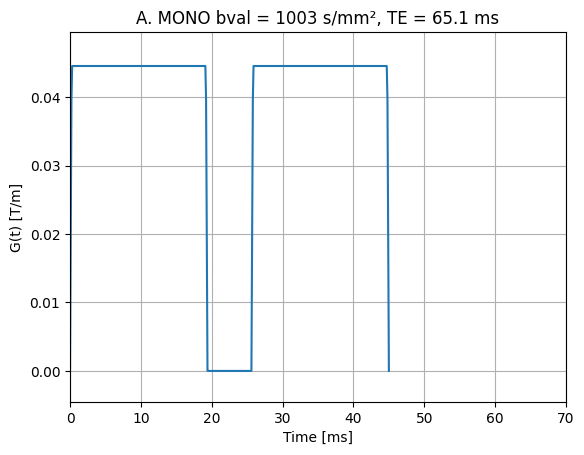

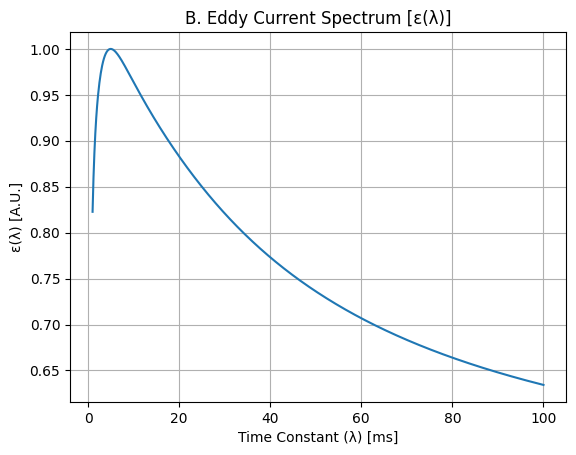

In [3]:
# Define parameters
params = {}
params['mode'] = 'diff_bval'
params['gmax'] = 45e-3         # Maximum gradient amplitude [T/m]
params['smax'] = 200           # Maximum slew rate [T/m/s]
params['MMT'] = 0              # Desired moment nulling (M0 = 0 for Monopolar)
params['b'] = 1000             # Diffusion b-value [s/mm^2]
params['T_readout'] = 0        # Time from start to center of EPI readout [ms]; Set T_readout=0 to force a monopolar solution
params['T_90'] = 0.0           # Duration of excitation pulse [ms]
params['T_180'] = 6.0          # Duration of refocusing pulse [ms]
params['dt'] = 100e-6          # Gradient raster time for optimization [s]
tmin = 5                       # Minimum time search [ms]
tmax = 100                     # Maximum time search [ms]
t_epi = 40                     # EPI readout duration [ms]

# Call GrOpt functions to design the gradient waveform
G, T_out = get_min_TE_diff(params, params['b'], tmin, tmax, params)
b = get_bval(G, params)
G = G.squeeze()

# Compute TE and time vector
TE = len(G) * params['dt'] * 1000 + t_epi / 2  # ms
t = 1000 * np.arange(0, len(G)) * params['dt']  # ms

# Plot Gradient Waveform
plt.figure()
plt.plot(t, -G)
plt.axis([0, 70, -0.1 * params['gmax'], 1.1 * params['gmax']])
plt.xlabel('Time [ms]')
plt.ylabel('G(t) [T/m]')
plt.title(f'A. MONO bval = {b:.0f} s/mm², TE = {TE:.1f} ms')
plt.grid(True)

# Eddy Current Spectrum
tau_vec = np.arange(1, 100.1, 0.1)  # ms
t_eddy = 1000 * np.arange(0, len(G) * params['dt'], params['dt'])  # ms
eddy_spectrum0 = []

for tau in tau_vec:
    eddy_response = np.convolve(np.diff(G), np.exp(-t_eddy / tau), mode='full')
    eddy_spectrum0.append(eddy_response[len(G)])

eddy_spectrum0 = np.array(eddy_spectrum0)
eddy_spectrum_max0 = np.max(eddy_spectrum0)

# Plot Eddy Spectrum
plt.figure()
plt.plot(tau_vec, eddy_spectrum0 / eddy_spectrum_max0)
plt.title('B. Eddy Current Spectrum [ε(λ)]')
plt.xlabel('Time Constant (λ) [ms]')
plt.ylabel('ε(λ) [A.U.]')
plt.grid(True)
plt.show()

#### 2. Convex Optimized Diffusion Encoding (CODE) Gradient Waveform Design

- How does the waveform shape compare? Is it longer shorter? Symmetric or asymetric?

- How do the eddy current spectra compare? Which one is better?

Testing TE = 52.500 76.250 64.375 70.312 67.344 68.828 69.570 69.199 69.014 68.921 68.875 68.851 Final TE = 68.851 ms


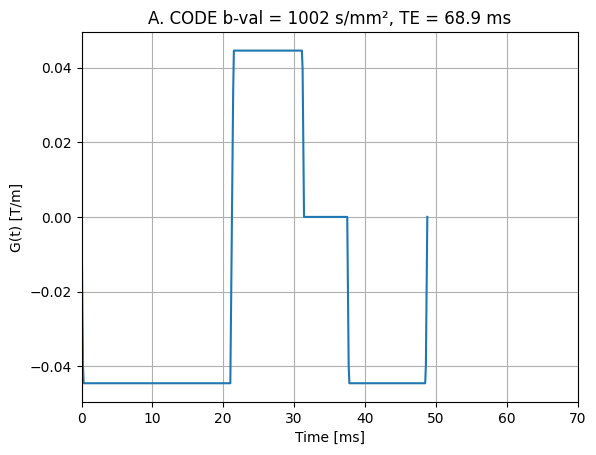

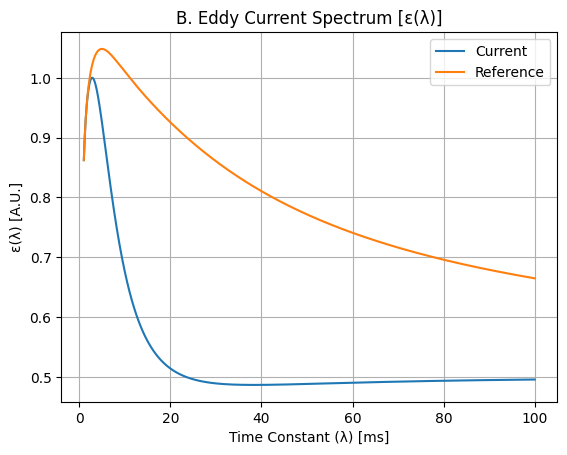

In [ ]:
# Define parameters
params = {}
params['mode'] = 'diff_bval'
params['gmax'] = 45e-3         # Maximum gradient amplitude [T/m]
params['smax'] = 200           # Maximum slew rate [T/m/s]
params['MMT'] = 0              # Desired moment nulling (M0 = 0 for Monopolar)
params['b'] = 1000             # Diffusion b-value [s/mm^2]
params['T_readout'] = 20        # Time from start to center of EPI readout [ms]; Set T_readout=0 to force a monopolar solution
params['T_90'] = 0.0           # Duration of excitation pulse [ms]
params['T_180'] = 6.0          # Duration of refocusing pulse [ms]
params['dt'] = 100e-6          # Gradient raster time for optimization [s]
tmin = 5                       # Minimum time search [ms]
tmax = 100                     # Maximum time search [ms]
t_epi = 40                     # EPI readout duration [ms]

# Call GrOpt functions to design the gradient waveform
G, T_out = get_min_TE_diff(params, params['b'], tmin, tmax, params)
b = get_bval(G, params)
G = G.squeeze()

TE = len(G) * params['dt'] * 1000 + params['T_readout']  # in ms
t = 1000 * np.arange(len(G)) * params['dt']  # in ms

# Plot G(t)
plt.figure()
plt.plot(t, G)
plt.axis([0, 70, -1.1 * params['gmax'], 1.1 * params['gmax']])
plt.xlabel('Time [ms]')
plt.ylabel('G(t) [T/m]')
plt.title(f'A. CODE b-val = {b:.0f} s/mm², TE = {TE:.1f} ms')
plt.grid(True)

# Eddy current spectrum
tau_vec = np.arange(1, 100.1, 0.1)  # [ms]
t_eddy = 1000 * np.arange(0, len(G) * params['dt'], params['dt'])  # [ms]

eddy_spectrum = []
for tau in tau_vec:
    response = np.convolve(np.diff(G), np.exp(-t_eddy / tau), mode='full')
    eddy_spectrum.append(response[len(G)])

eddy_spectrum = np.array(eddy_spectrum)
eddy_spectrum_max0 = np.max(eddy_spectrum)

plt.figure()
plt.plot(tau_vec, eddy_spectrum / eddy_spectrum_max0, label='Current')
plt.plot(tau_vec, eddy_spectrum0 / eddy_spectrum_max0, label='Reference')
plt.title('B. Eddy Current Spectrum [ε(λ)]')
plt.xlabel('Time Constant (λ) [ms]')
plt.ylabel('ε(λ) [A.U.]')
plt.legend()
plt.grid(True)

plt.show()


#### 3. Eddy Current Nulled CODE (EN-CODE)

Use GrOpt to null an eddy current time constant of 50 ms.

- What happened to the gradient waveform shape and timing? 

- What happened to the diffusion encoding gradient waveform duration?

- What happened to the eddy current spectrum at 50ms? What might this imply for an EPI readout?


Testing TE = 52.500 76.250 88.125 82.188 79.219 80.703 81.445 81.816 82.002 82.095 82.141 82.164 Final TE = 82.164 ms


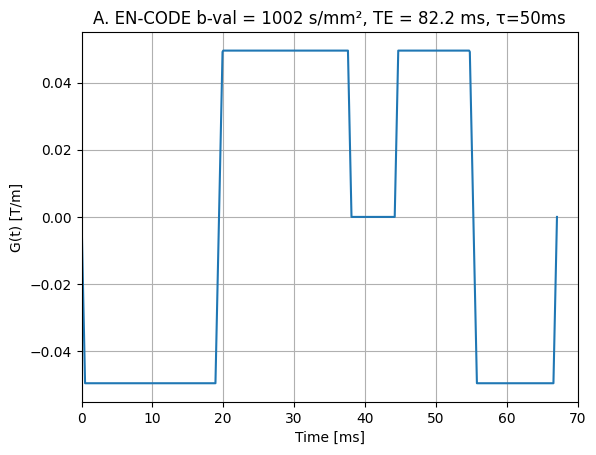

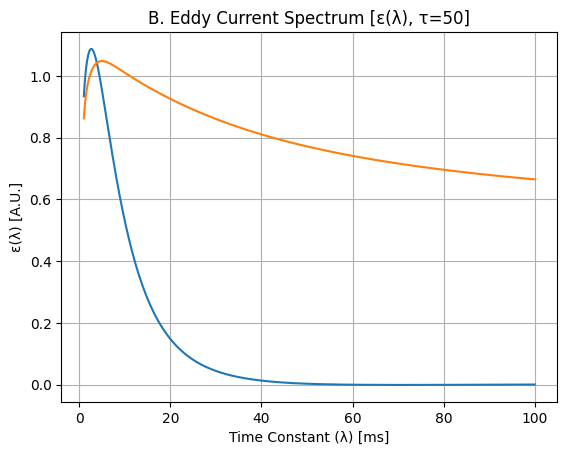

In [ ]:
# Define parameters
params = {}
params['mode'] = 'diff_bval'
params['gmax'] = 50e-3         # Maximum gradient amplitude [T/m]
params['smax'] = 100           # Maximum slew rate, [T/m/s]
params['MMT'] = 0              # Desired moment nulling (M0 = 0 for Monopolar)
params['b'] = 1000             # Diffusion b-value, [s/mm^2]
params['T_readout'] = 15       # Time from start to center of EPI readout [ms]
params['T_90'] = 0             # Duration of excitation pulse [ms]
params['T_180'] = 6            # Duration of refocusing pulse [ms]
params['dt'] = 100e-6          # Gradient raster time for optimization [s]
tmin = 5                       # Minimum time search [ms]
tmax = 100                     # Maximum time search [ms]
params['eddy_params'] = []     # Eddy current compensation [time constant (ms), target, tolerance, mode]

tau = 50                       # Eddy current time constant to null [ms]
params['eddy_params'].append([tau, 0, 1.0e-4, 0])

# Call GrOpt functions to design the gradient waveform
G, T_out = get_min_TE_diff(params, params['b'], tmin, tmax, params)
b = get_bval(G, params)
G = G.squeeze()

TE = len(G) * params['dt'] * 1000 + params['T_readout']

# Plot gradient waveform
t = 1000 * np.arange(0, len(G)) * params['dt']
plt.figure()
plt.plot(t, G)
plt.axis([0, 70, -1.1 * params['gmax'], 1.1 * params['gmax']])
plt.xlabel('Time [ms]')
plt.ylabel('G(t) [T/m]')
plt.title(f'A. EN-CODE b-val = {b:.0f} s/mm², TE = {TE:.1f} ms, τ={tau}ms')
plt.grid(True)

# Generate the eddy current spectrum
tau_vec = np.arange(1, 100.1, 0.1)  # Range of time constants [ms]
t_eddy = 1000 * np.arange(0, len(G)+1) * params['dt']
eddy_spectrum = []

for tau_k in tau_vec:
    eddy_response = np.convolve(np.diff(G), np.exp(-t_eddy / tau_k))[:len(G)]
    eddy_spectrum.append(eddy_response[-1])

eddy_spectrum = np.array(eddy_spectrum)

# Plot eddy current spectrum
plt.figure()
plt.plot(tau_vec, eddy_spectrum / eddy_spectrum_max0)
plt.plot(tau_vec, eddy_spectrum0 / eddy_spectrum_max0)
plt.title(f'B. Eddy Current Spectrum [ε(λ), τ={tau}]')
plt.xlabel('Time Constant (λ) [ms]')
plt.ylabel('ε(λ) [A.U.]')
plt.grid(True)
plt.show()


In [ ]:
#### 4. 